<a href="https://colab.research.google.com/github/ksb25395/CAP6779/blob/master/Distant_supervised_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/datasets/glove.twitter.27B.200d.txt.zip" 

Archive:  /content/gdrive/My Drive/Colab Notebooks/datasets/glove.twitter.27B.200d.txt.zip
  inflating: glove.twitter.27B.200d.txt  


In [0]:
# from gensim.models import KeyedVectors
# EMBEDDING_FILE = '/content/gdrive/My Drive/Colab Notebooks/datasets/Google/GoogleNews-vectors-negative300.bin.gz'
# word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/content/glove.twitter.27B.200d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
word2vec = KeyedVectors.load_word2vec_format(tmp_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# imports 
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup

In [0]:
cols = ['sentiment','id','date','query_string','user','text']
df_train=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/distant_supervision_data/training.1600000.processed.noemoticon.csv', usecols = [0,5],names=cols, encoding='latin-1')
df_train.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [0]:
df_train["sentiment"] = df_train["sentiment"].replace(4, 1)

In [0]:
# drop rows with retweet text 
df_train.drop(df_train[df_train.text.str.contains(' RT ')].index, inplace=True)

In [0]:
clean_tweets = []
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet

In [0]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [0]:
df_train["clean_text"] = df_train["text"].apply(lambda x : clean(x))

In [0]:
df_train.head()

,sentiment,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- aww, that's a bummer. you shoulda got dav..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."


In [0]:
import nltk
import spacy
import string
# preprocessing methods
# Removal of URLs
def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

# Remove @ mentions
def remove_mentions(text):
  text = re.sub(r"(?:\@|https?\://)\S+", "", text)
  return text

# strip links
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

# strip entities
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

# convert emojis
!pip install emot
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
def convert_emoticons(text):
  for emot in EMOTICONS:
    re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
  return text

# convert emoji to word
!pip install emoji
import emoji
def convert_emojis(text):
    return emoji.demojize(text)

# expand contractions
!pip install -q contractions
import contractions
def expand_contractions(text):
  return contractions.fix(text)

# remove punctuations
PUNCT = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT))

# remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# remove frequent words
def remove_freqwords(text, FREQ_WORDS):
  return " ".join([word for word in str(text).split() if word not in FREQ_WORDS])

# remove rare words
def remove_rarewords(text, RAREWORDS):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

# lemmatize words
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# spelling correction

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=9587b67c81f535661e1d5332743961f8f96032a9e41c0e0ad6a9f73439222033
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 245kB 3.6MB/s 
     |████████████████████████████████| 317kB 20.3MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
def preprocess(df):
  # Lower casing
  df["text"] = df["text"].str.lower()
  df.head()
  # remove urls
  df["text"] = df["text"].apply(lambda x : remove_urls(x))
  # remove mentions
  df["text"] = df["text"].apply(lambda x: remove_mentions(x))
  # strip links
  df["text"] = df["text"].apply(lambda x: strip_links(x))
  # strip all entities
  df["text"] = df["text"].apply(lambda x: strip_all_entities(x))
  # convert all emoticons
  df["text"] = df["text"].apply(lambda x : convert_emoticons(x))
  # convert all emojis
  df["text"] = df["text"].apply(lambda x : convert_emojis(x))
  # expand all contractions
  df["text"] = df["text"].apply(lambda x : expand_contractions(x))
  # remove all punctuations
  df["text"] = df["text"].apply(lambda x : remove_punctuation(x))
  # remove all stopwords
  df["text"] = df["text"].apply(lambda x : remove_stopwords(x))
  # remove frequent words
  from collections import Counter
  cnt = Counter()
  for text in df["text"].values:
    for word in text.split():
      cnt[word] += 1
  FREQ_WORDS = set([word for (word, count) in cnt.most_common(10)])
  df["text"] = df["text"].apply(lambda x : remove_freqwords(x, FREQ_WORDS))
  # remove rare words
  n_rare_words = 10
  RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
  df["text"] = df["text"].apply(lambda text: remove_rarewords(text, RAREWORDS))
  # lemmatize words
  df["text"] = df["text"].apply(lambda text: lemmatize_words(text))
  # spelling correction
  return df

In [0]:
semeval_df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/datasets/Semeval-2017-4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt', sep="\t", header=None)
semeval_df = semeval_df.drop(columns=3)
semeval_df.columns = ['id', 'sentiment', 'text']

In [0]:
semeval_df = preprocess(semeval_df)
semeval_df.head()

,id,sentiment,text
0,619950566786113536,neutral,picturehouse pink floyd roger water walll open...
1,619969366986235905,neutral,order go set watchman store website tuesday ge...
2,619971047195045888,negative,runway renovation airport prevent see taylor s...
3,619974445185302528,neutral,could ask onstage interview question miss usa ...
4,619987808317407232,positive,portion book sale harper lee go set watchman r...


In [0]:
df_new = df_train.sample(n=1000000, random_state = 1)

In [0]:
train_set = set()
for tweet in df_new["clean_text"]:
  for word in tweet.split():
    train_set.add(word)
semeval_set = set()
for tweet in semeval_df["text"]:
  for word in tweet.split():
    semeval_set.add(word)

In [0]:
common_words = list(train_set & semeval_set) 
len(common_words)

13961

In [0]:
len(train_set) + len(semeval_set) - len(common_words)

527762

In [0]:
len(semeval_set)

18610

We can see that out of 18610 unique tokens in semeval dataset, we have 10560 unique tokens present in the distant supervised tweet dataset.

In [0]:
# Tokenizer illustration example
from keras.preprocessing.text import Tokenizer
# define 5 documents
t  = Tokenizer(oov_token='oov')
fit_text = ["The earth is an awesome place live"]
t.fit_on_texts(fit_text)

#fit_on_texts fits on sentences when list of sentences is passed to fit_on_texts() function. 
#ie - fit_on_texts( [ sent1, sent2, sent3,....sentN ] )

#Similarly, list of sentences/single sentence in a list must be passed into texts_to_sequences.
test_text1 = "The earth is an great place live"
test_text2 = "The is my program"
sequences = t.texts_to_sequences([test_text1, test_text2])

print('sequences : ',sequences,'\n')

print('word_index : ',t.word_index)
#texts_to_sequences() returns list of list. ie - [ [] ]

Using TensorFlow backend.


sequences :  [[2, 3, 4, 5, 1, 7, 8], [2, 4, 1, 1]] 

word_index :  {'oov': 1, 'the': 2, 'earth': 3, 'is': 4, 'an': 5, 'awesome': 6, 'place': 7, 'live': 8}


In [0]:
ds_texts = df_new["text"]

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(ds_texts)
sequences = tokenizer.texts_to_sequences(ds_texts)
word_index = tokenizer.word_index
print(len(word_index))

486528


In [0]:
X_train = pad_sequences(sequences)
y_train = to_categorical(list(df_new["sentiment"]))

In [0]:
EMBED_DIM = 200
vocab_size = len(word_index) + 1
embedding_matrix = np.random.normal(0,np.sqrt(0.25),[vocab_size, EMBED_DIM])

In [0]:
count = []
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vec = word2vec[word]
        embedding_matrix[i] = embedding_vec
    except KeyError:
        count.append(word)
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBED_DIM)

In [0]:
len(count)

374880

In [0]:
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding

In [0]:
from keras.layers import Embedding
embedding_layer = Embedding(vocab_size,
                            EMBED_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
seq_len = X_train.shape[1]
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dropout
inputs = Input(shape=(seq_len,))
embeddings = embedding_layer(inputs)
# flattened = Flatten()(embeddings)
lstm = LSTM(200, dropout=0.5)(embeddings)
dense0 = Dense(128, activation="relu")(lstm)
# dropout0 = Dropout()(dense0)
dense1 = Dense(64, activation="relu")(dense0)
dropout1 = Dropout(rate=0.25)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
dropout2 = Dropout(rate=0.25)(dense2)
dense3 = Dense(16, activation="relu")(dropout2)
output = Dense(y_train.shape[1], activation='softmax')(dense3)
model = Model(inputs, output)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
!pip install keras-rectified-adam
from keras_radam import RAdam

from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=e83f1ee0f7663a475755c1c903b124b98b7e43f844734771d9b1c8851b54e222
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [0]:
from keras.optimizers import Adam, Nadam, Adadelta, SGD, RMSprop
# Adadelta performs poorly
# Adam performs better than Nadam
# SGD fares poorly
# Default adam lr = 2e-3
opt = RAdam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy', f1_m, precision_m, recall_m])

# from keras.callbacks import LearningRateScheduler
# import math
# # learning rate schedule
# def step_decay(epoch):
# 	initial_lrate = 0.01
# 	drop = 0.1
# 	epochs_drop = 5.00
# 	lrate = initial_lrate * math.pow(drop, ((1+epoch)/epochs_drop))
# 	return min(1e-4, lrate)

# # learning schedule callback
# lrate = LearningRateScheduler(step_decay)
# # from keras.callbacks import EarlyStopping
# # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
model.fit(X_train, y_train, batch_size=1000, epochs=5, verbose=1, shuffle=True, validation_split=0.005)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 995000 samples, validate on 5000 samples
Epoch 1/5
995000/995000 [==============================] - 3916s 4ms/step - loss: 0.5016 - acc: 0.7466 - f1_m: 0.7466 - precision_m: 0.7466 - recall_m: 0.7466 - val_loss: 0.4180 - val_acc: 0.8048 - val_f1_m: 0.8048 - val_precision_m: 0.8048 - val_recall_m: 0.8048
Epoch 2/5
995000/995000 [==============================] - 3909s 4ms/step - loss: 0.4104 - acc: 0.8134 - f1_m: 0.8134 - precision_m: 0.8134 - recall_m: 0.8134 - val_loss: 0.3988 - val_acc: 0.8230 - val_f1_m: 0.8230 - val_precision_m: 0.8230 - val_recall_m: 0.8230
Epoch 3/5
995000/995000 [==============================] - 3913s 4ms/step - loss: 0.3699 - acc: 0.8352 - f1_m: 0.8352 - precision_m: 0.8352 - recall_m: 0.8352 - val_loss: 0.3936 - val_acc: 0.8234 - val_f1_m: 0.8234 - val_precision_m: 0.8234 - val_recall_m: 0.8234
Epoch 4/5
995000/995000 [==============================] - 390

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/distant_tweets_pretrained.h5')

In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/distant_tweets_pretrained.h5', compile=False)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 118)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 118, 200)          97305800  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080

In [0]:
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 118)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 118, 200)          97305800  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
Total params: 97,626,600
Trainable params: 97,626,600
Non-trainable params: 0
_________________________________________________________________


In [0]:
semeval_df.sentiment = semeval_df.sentiment.astype('category')
semeval_df["sentiment"] = semeval_df["sentiment"].cat.codes
semeval_df.head()

,id,sentiment,text
0,619950566786113536,1,picturehouse pink floyd roger water walll open...
1,619969366986235905,1,order go set watchman store website tuesday ge...
2,619971047195045888,0,runway renovation airport prevent see taylor s...
3,619974445185302528,1,could ask onstage interview question miss usa ...
4,619987808317407232,2,portion book sale harper lee go set watchman r...


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(semeval_df, semeval_df["sentiment"]):
    train_set = semeval_df.loc[train_idx]
    test_set = semeval_df.loc[test_idx]

print(train_set["sentiment"].value_counts())
print(test_set["sentiment"].value_counts())

1    8273
2    5647
0    2585
Name: sentiment, dtype: int64
1    2069
2    1412
0     646
Name: sentiment, dtype: int64


In [0]:
semeval_train_texts = train_set["text"]
semeval_test_texts = test_set["text"]

In [0]:
semeval_train_sequences = tokenizer.texts_to_sequences(semeval_train_texts)
X_semeval_train = pad_sequences(semeval_train_sequences, X_train.shape[1])
y_semeval_train = to_categorical(list(train_set["sentiment"]))

In [0]:
semeval_test_sequences = tokenizer.texts_to_sequences(semeval_test_texts)
X_semeval_test = pad_sequences(semeval_test_sequences, X_train.shape[1])
y_semeval_test = to_categorical(list(test_set["sentiment"]))

In [0]:
X_semeval_train.shape

(16505, 118)

In [0]:
dense0 = Dense(128, activation='relu')(model.layers[-1].output)
dropout0 = Dropout(rate=0.2)(dense0)
dense1 = Dense(64, activation='relu')(dropout0)
dropout1 = Dropout(rate=0.2)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
dropout2 = Dropout(rate=0.2)(dense2)
dense3 = Dense(16, activation="relu")(dropout2)
output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)

# from keras.layers import BatchNormalization
# dense0 = Dense(128, activation='relu')(model.layers[-1].output)
# batchn0 = BatchNormalization()(dense0)
# dense1 = Dense(64, activation='relu')(batchn0)
# batchn1 = BatchNormalization()(dense1)
# dense2 = Dense(32, activation="relu")(batchn1)
# batchn2 = BatchNormalization()(dense2)
# dense3 = Dense(16, activation="relu")(batchn2)
# output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)

# dense0 = Dense(128, activation='relu')(model.layers[-1].output)
# batchn0 = BatchNormalization()(dense0)
# dropout0 = Dropout(rate=0.25)(batchn0)
# dense1 = Dense(64, activation='relu')(dropout0)
# batchn1 = BatchNormalization()(dense1)
# dropout1 = Dropout(rate=0.25)(batchn1)
# dense2 = Dense(32, activation="relu")(batchn1)
# batchn2 = BatchNormalization()(dense2)
# dropout2 = Dropout(rate=0.25)(batchn2)
# dense3 = Dense(16, activation="relu")(dropout2)
# output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)

In [0]:
seq_len_semeval = X_semeval_train.shape[1]
new_model = Model(input=model.input, output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 118)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 118, 200)          97305800  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25728     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0   

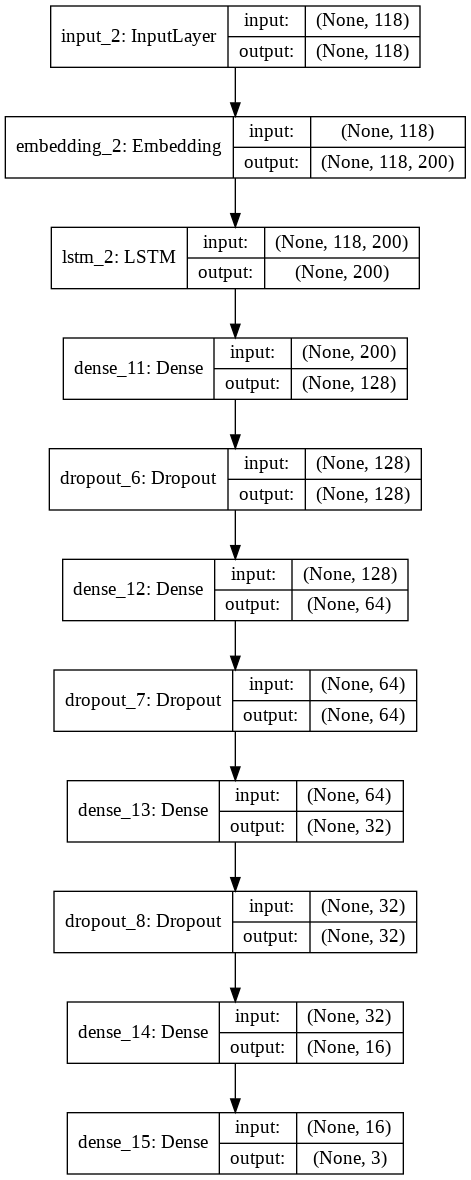

In [0]:
new_model.summary()
from keras.utils import plot_model
plot_model(new_model, to_file='model2.png', show_shapes=True)

In [0]:
# Make embeddings non-trainable
new_model.layers[1].trainable = False
# new_model.layers[2].trainable = False

In [0]:
from keras.optimizers import Adam, Nadam, Adadelta, SGD, RMSprop
# Adadelta performs poorly
# Adam performs better than Nadam
# SGD fares poorly
# Default adam lr = 2e-3
opt = RAdam()

new_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy', f1_m, precision_m, recall_m])

# from keras.callbacks import LearningRateScheduler
# import math
# # learning rate schedule
# def step_decay(epoch):
# 	initial_lrate = 0.01
# 	drop = 0.1
# 	epochs_drop = 5.00
# 	lrate = initial_lrate * math.pow(drop, ((1+epoch)/epochs_drop))
# 	return min(1e-4, lrate)

# # learning schedule callback
# lrate = LearningRateScheduler(step_decay)
# # from keras.callbacks import EarlyStopping
# # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
print(X_semeval_train.shape, y_semeval_train.shape)

(16505, 118) (16505, 3)


In [0]:
history = new_model.fit(X_semeval_train, y_semeval_train, batch_size=500, epochs=20, verbose=1, shuffle=True, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 13204 samples, validate on 3301 samples
Epoch 1/20
13204/13204 [==============================] - 46s 3ms/step - loss: 1.1128 - acc: 0.2865 - f1_m: 0.0011 - precision_m: 0.1382 - recall_m: 5.3014e-04 - val_loss: 1.0693 - val_acc: 0.4789 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
13204/13204 [==============================] - 43s 3ms/step - loss: 1.0472 - acc: 0.4831 - f1_m: 0.0098 - precision_m: 0.2203 - recall_m: 0.0051 - val_loss: 1.0060 - val_acc: 0.4841 - val_f1_m: 6.0346e-04 - val_precision_m: 0.0757 - val_recall_m: 3.0294e-04
Epoch 3/20
13204/13204 [==============================] - 43s 3ms/step - loss: 0.9921 - acc: 0.5042 - f1_m: 0.2653 - precision_m: 0.5267 - recall_m: 0.1871 - val_loss: 0.9649 - val_acc: 0.4883 - val_f1_m: 0.4130 - val_precision_m: 0.5077 - val_recall_m: 0.3481
Epoch 4/20
13204/13204 [========================

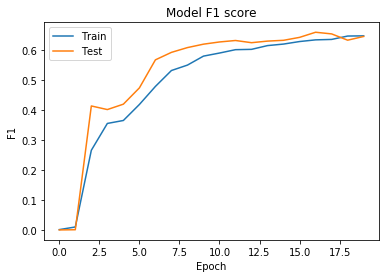

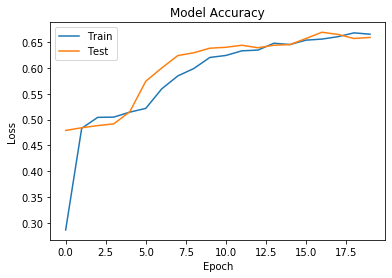

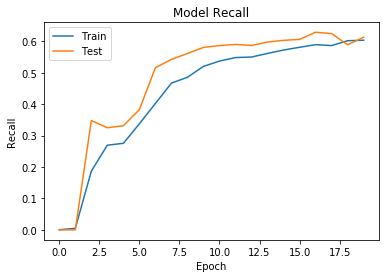

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1 score')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
new_model.evaluate(X_semeval_test, y_semeval_test)

4127/4127 [==============================] - 5s 1ms/step


[0.749794375587382,
 0.6624666827121312,
 0.6462260271450322,
 0.6838787426187711,
 0.6135207171269124]

In [0]:
y_pred = new_model.predict(X_semeval_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_semeval_test, axis=1)
from sklearn.metrics import classification_report, f1_score, accuracy_score, recall_score
print(f1_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='macro'))
print(classification_report(y_true, y_pred))

0.6384798522876047
0.6355431572571364
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       646
           1       0.67      0.75      0.70      2069
           2       0.71      0.57      0.64      1412

    accuracy                           0.66      4127
   macro avg       0.65      0.64      0.64      4127
weighted avg       0.67      0.66      0.66      4127



Results of Ablation tests:
1.   Embedding frozen but LSTM trainable : 
2.   Embedding trainable but LSTM frozen
3.   Embedding and LSTM both trainable : 0.6003421



In [0]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/distant_tweets_pretrained.h5')
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 49)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 49, 300)           33786000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080

In [0]:
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 38)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 38, 300)           33754500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
Total params: 34,501,766
Trainable params: 34,501,766
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
dense0 = Dense(128, activation='softmax')(model.layers[-1].output)
dense1 = Dense(64, activation='softmax')(dense0)
dropout1 = Dropout(rate=0.25)(dense1)
dense2 = Dense(32, activation="relu")(dropout1)
dropout2 = Dropout(rate=0.25)(dense2)
dense3 = Dense(16, activation="relu")(dropout2)
output = Dense(y_semeval_train.shape[1], activation='softmax')(dense3)

Freeze embedding but LSTM trainable


In [0]:
# model.layers[1].trainable = False

In [0]:
new_model = Model(input=model.input, output=[output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [0]:
new_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 38)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 38, 300)           33754500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_35 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080

In [0]:
from keras.optimizers import Adam
adam = Adam(lr=1e-3)

new_model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

In [0]:
new_model.fit(X_semeval_train, y_semeval_train, batch_size=1000, epochs=20, verbose=1, shuffle=True, validation_split=0.2)

Train on 13204 samples, validate on 3301 samples
Epoch 1/20
13204/13204 [==============================] - 83s 6ms/step - loss: 1.0336 - acc: 0.4716 - val_loss: 0.9563 - val_acc: 0.4838
Epoch 2/20
 8000/13204 [=================>............] - ETA: 28s - loss: 0.9518 - acc: 0.5047

KeyboardInterrupt: ignored

In [0]:
new_model.evaluate(X_semeval_test, y_semeval_test)

4127/4127 [==============================] - 2s 462us/step


[0.872562335670962, 0.6290283499776176]

In [0]:
y_pred = new_model.predict(X_semeval_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_semeval_test, axis=1)
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro')

0.5830646250813123